### 一.算法介绍
层次聚类试图在不同层次对数据集进行划分，从而形成树形的聚类结构。数据集的划分有两种策略：一种是自下而上，另一种是自上而下；自下而上初始将每个样本视作一个单独的簇，然后选择相距最近的两个样本进行合并，循环执行，直到达到预设的聚类簇个数，而自上而下恰好相反，它假设所有样本都属于同一个簇，然后将相距最远样本进行划分....，这一节我们实现AGglomerative NESting（AGNES）算法，一种自下而上的算法，它的原理其实刚刚已经提到了：    

**相距最近的两个簇进行合并，直至达到预设的聚类簇个数**  

所以，核心问题变成如何度量两个簇之间的距离，这在上一节已经做过介绍了，AGNES通常采用类间最小、最大、平均距离这三种，分别对应的算法被称作“单链接”，“全链接”和“均链接”，其聚类过程可以类似如下的“树状图”，[图片来源于>>>](https://blog.csdn.net/weixin_44530236/article/details/89160137)：   

![avatar](./source/18_聚类_AGNES.png)  

这里，横坐标表示样本id，纵坐标表示类间距离，树形图即是我们的聚类过程

### 二.算法流程
>输入：样本集$D=\{x_1,x_2,...,x_m\}$;聚类簇距离度量函数$d$;聚类簇数$k$；  

>过程：

>（1） 对$j=1,2,...,m$
>> $G_j=\{x_j\}$  

>（2） 对$i=1,2,..,m$
>> 对$j=1,2,...,m$
>>> 
$$
M(i,j)=d(G_i,G_j)\\
M(j,i)=M(i,j)
$$

>（3） 设置当前聚类簇个数$q=m$，当$q>k$时，循环执行以下过程  
>>（3.1）找出距离最近的两个聚类簇$G_{i^*}$和$G_{j^*}$（$i^*<j^*$）；   

>>（3.2）合并$G_{i^*}$和$G_{j^*}$：$G_{i^*}=G_{i^*}\bigcup G_{j^*}$；   

>>（3.3） 对$j=j^*+1,j^*+2,...,q$  

>>> 将聚类簇$G_j$重新编号为$G_{j-1}$

>>（3.4）删除距离矩阵$M$的第$j^*$行与第$j^*$列（注意，矩阵的行列都要减1）  

>>（3.5）对$j=1,2,...,q-1$
$$
M(i^*,j)=d(G_{i^*},G_j)\\
M(j,i^*)=M(i^*,j)
$$
>>（3.6）$q=q-1$  

>输出$G=\{G_1,G_2,...,G_k\}$

### 三.代码实现
为了代码简便，距离计算就只实现了：（1）样本距离为欧氏距离；（2）类间距离为平均距离的情况，其他组合情况，还请自行定义

In [5]:
"""
层次聚类：AGNES的实现，代码封装在ml_models.agnes
"""

import numpy as np


# 定义默认的距离函数
def euclidean_average_dist(Gi, Gj):
    return np.sum(np.power(np.mean(Gi, axis=0) - np.mean(Gj, axis=0), 2))


class AGNES(object):
    def __init__(self, k=3, dist_method=None):
        """
        :param k: 聚类数量
        :param dist_method: 距离函数定义
        """
        self.k = k
        self.dist_method = dist_method
        if self.dist_method is None:
            self.dist_method = euclidean_average_dist
        # self.G = None
        self.cluster_center = {}  # 记录聚类中心点

    def fit(self, X):
        m, _ = X.shape
        # 初始化簇
        G = {} 
        for row in range(m):
            G[row] = X[[row]]
        # 计算簇间距离
        M = np.zeros(shape=(m, m))
        for i in range(0, m):
            for j in range(0, m):
                M[i, j] = self.dist_method(G[i], G[j])
                M[j, i] = M[i, j]
        q = m
        while q > self.k:
            # 寻找最近的簇
            min_dist = np.infty
            i_ = None
            j_ = None
            for i in range(0, q - 1):
                for j in range(i + 1, q):
                    if M[i, j] < min_dist:
                        i_ = i
                        j_ = j
                        min_dist = M[i, j]
            # 合并
            G[i_] = np.concatenate([G[i_], G[j_]])
            # 重编号
            for j in range(j_ + 1, q):
                G[j - 1] = G[j]
            # 删除G[q]
            del G[q-1]
            # 删除
            M = np.delete(M, j_, axis=0)
            M = np.delete(M, j_, axis=1)
            # 更新距离
            for j in range(q - 1):
                M[i_, j] = self.dist_method(G[i_], G[j])
                M[j, i_] = M[i_, j]
            # 更新q
            q = q - 1
#         self.G = G
        for idx in G:
            self.cluster_center[idx] = np.mean(G[idx], axis=0)

    def predict(self, X):
        rst = []
        rows, _ = X.shape
        for row in range(rows):
            # vec = X[[row]]
            vec = X[row]
            min_dist = np.infty
            bst_label = None
            for idx in self.cluster_center:
                # dist = self.dist_method(vec, self.G[idx]) < min_dist
                dist = np.sum(np.power(vec - self.cluster_center[idx], 2))
                if dist < min_dist:
                    bst_label = idx
                    min_dist = dist
            rst.append(bst_label)
        return np.asarray(rst)

### 四.测试

In [6]:
import os
os.chdir('../')
from ml_models import utils
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

In [7]:
#训练
agnes = AGNES(k=4)
agnes.fit(X)

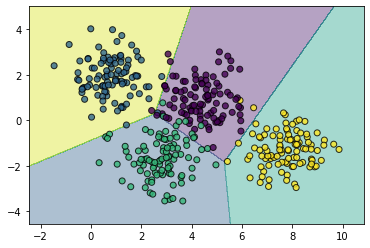

In [8]:
utils.plot_decision_function(X, y, agnes)
utils.plt.show()